# Topic Classification On StackOverflow Dataset

- The stackoverflow dataset can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)
- after download, extract the content of zip file to your local directory

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.6.2


In [3]:
dataset_dir = os.path.join(os.path.dirname('.'), 'stackoverflow')

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [5]:
sample_file = os.path.join(train_dir, 'java/2.txt')
with open(sample_file) as f:
  print(f.read())

"identifier required when invoking a private method i am calling a private method for testing and for that i am using the following code to invoke private method. repeat() is the private method of class diamond..import org.junit.test;.import static org.junit.assert.*;.import blank.lang.stringbuilder;.import blank.lang.reflect.method;.public class diamondunit {.        stringbuilder expect = new stringbuilder();.        diamond test = new diamond();.        method m = test.getclass().getdeclaredmethod(""repeat"");.        m.setaccessible(true);.        m.invoke(test);..    @test.        public void testrepeatneg() {.            assertequals("""", test.repeat(expect,""a"",-1));.        }.}...while compiling it is giving error ..diamondunit.blank:11: error: expected.m.setaccessible(true);.^.diamondunit.blank:11: error: illegal start of type.m.setaccessible(true);.^.diamondunit.blank:12: error: expected.m.invoke(test);.^.diamondunit.blank:12: error: expected.m.invoke(test);.^...i had cop p

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('stackoverflow/train', 
                                                          batch_size=batch_size, 
                                                          validation_split=0.2, 
                                                          subset='training', 
                                                          seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2022-04-16 06:17:42.030883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-16 06:17:42.030976: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 06:17:42.030996: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7cba28e36cbd): /proc/driver/nvidia/version does not exist
2022-04-16 06:17:42.031285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

2022-04-16 06:17:45.747776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stackoverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('stackoverflow/test', 
                                                         batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [31]:
max_features = 15000
sequence_length = 500

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [32]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [33]:
vocab_list = vectorize_layer.get_vocabulary()
print(vocab_list[0:20])
len(vocab_list)

['', '[UNK]', 'the', 'i', 'to', 'a', 'is', 'in', 'and', 'of', 'if', 'it', 'for', 'this', 'that', 'new', 'blank', 'have', 'string', '0']


15000

In [34]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [35]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("first review", first_review)
print("first label", first_label)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

first review tf.Tensor(b'"trying to convert a list of date(actrived from database) to format(yyyy-mm) public list&lt;date&gt; getdate(){.    @suppresswarnings(""unchecked"").    list&lt;string&gt; cr =          (list&lt;string&gt;)getsession().createcriteria(orderentity.class).            .setprojection(projections.projectionlist().                    .add(property.forname(""ordertime"")).                    ).            .list();.    system.out.println(""zxcv"");.    system.out.println(cr);//the output is here [2017-10-23 15:15:53.0, 2017-10-25 11:53:56.0, 2017-10-25 11:54:35.0}.    list&lt;date&gt; dates = new arraylist(cr.size());.    simpledateformat sdf = new simpledateformat(""yyyy-mm"");.    for (string datestring : cr) {.        dates.add(sdf.parse(datestring));.    }.    system.out.println(dates);.    return dates;.}...there is the error :...  blank.sql.timestamp cannot be cast to blank.lang.string....please tell me how to solve this error,.thank you so much."\n', shape=(), dt

In [36]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 15000


In [37]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [39]:
embedding_dim = 300
model = tf.keras.Sequential([
  layers.Embedding(max_features+1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         4500300   
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1204      
Total params: 4,501,504
Trainable params: 4,501,504
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [41]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
200/200 [==============================] - 15s 72ms/step - loss: 1.3643 - accuracy: 0.3477 - val_loss: 1.3336 - val_accuracy: 0.3850
Epoch 2/20
200/200 [==============================] - 13s 63ms/step - loss: 1.2638 - accuracy: 0.5264 - val_loss: 1.1917 - val_accuracy: 0.6331
Epoch 3/20
200/200 [==============================] - 13s 64ms/step - loss: 1.0950 - accuracy: 0.6461 - val_loss: 1.0219 - val_accuracy: 0.7125
Epoch 4/20
200/200 [==============================] - 14s 69ms/step - loss: 0.9342 - accuracy: 0.7166 - val_loss: 0.8858 - val_accuracy: 0.7394
Epoch 5/20
200/200 [==============================] - 13s 66ms/step - loss: 0.8035 - accuracy: 0.7603 - val_loss: 0.7856 - val_accuracy: 0.7644
Epoch 6/20
200/200 [==============================] - 18s 88ms/step - loss: 0.7024 - accuracy: 0.7925 - val_loss: 0.7134 - val_accuracy: 0.7775
Epoch 7/20
200/200 [==============================] - 15s 73ms/step - loss: 0.6250 - accuracy: 0.8180 - val_loss: 0.6591 - val_accuracy:

### Evaluate the model

In [42]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 6s 24ms/step - loss: 0.5491 - accuracy: 0.7961
Loss:  0.549095630645752
Accuracy:  0.7961249947547913


### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [43]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

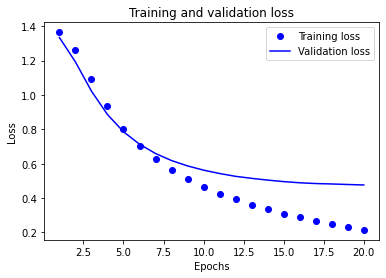

In [44]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

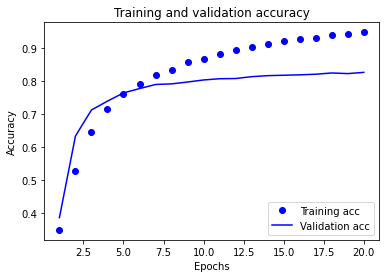

In [45]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [47]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer="adam",
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 6s 21ms/step - loss: 1.0594 - accuracy: 0.7951
0.7951250076293945


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [48]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.620148  , 0.6312625 , 0.65349984, 0.5737578 ],
       [0.6073457 , 0.64249974, 0.64941573, 0.5789184 ],
       [0.61449695, 0.630679  , 0.6513164 , 0.5819906 ]], dtype=float32)